In [19]:
#imports and set up

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from IPython.display import display
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import time
import sys
from process_pickle import process_pickle
%matplotlib inline
from ipywidgets import interact, interactive, fixed #Sliders for image selection
import ipywidgets as widgets
mpl.rc('figure',  figsize=(4.77, 2.95))
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['lines.linewidth'] = 0.6
mpl.rcParams['lines.color'] = 'r'
plt.rc('grid', linestyle="--", color='gray')


import numpy as np
import pandas as pd
from pandas import DataFrame, Series  

import pims
import trackpy as tp
import os

In [20]:
# function that is called to configure how plots are to be drawn

def setup_plot():
    ax = plt.gca()
    SPINE_COLOR = 'gray'
    for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(4.77, 2.95, forward=True)

Use the file picker to locate the .pkl containing the particle trajectories

or select a previously output .xlsx to skip the calculations

**If it doesn't appear you probably need to minimise your browser or alt tab around for it**

In [21]:
set_custom_data_directory = True

In [22]:
# select the .pkl files you wish to analyse. When you're done selecting cancel should
# allow you to continue to the next cell.

import tkinter as tk
from tkinter import filedialog

pkl_to_process = []
file_path = "1"
while len(file_path) != 0:
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename()
    if len(file_path) != 0:
        pkl_to_process.append(file_path)

In [23]:
# confirm you've selected the correct files

pkl_to_process

['C:/Users/lc16629/OneDrive - University of Bristol/Desktop/Python/500frm sample - 26-1-18 0.8gL 25C 1min/trajectories.pkl']

In [24]:
calculate = True

In [25]:
# configure the calculations to be carried out on the data contained in the .pkl files
# if you don't enter "NEXT" at the end you can queue another set of calculations to be carried out on the 
# same .pkl, e.g with a frame lookback.
pkl_param = []

i = 0
mpp = 15 # microns per pixel
timestep = 30 # seconds between images

while i < len(pkl_to_process):
    print(pkl_to_process[i])
    print("Setting Parameters...")
    # uncomment the below lines to set mpp or timestep on a per .pkl basis
    #mpp = int(input("Microns per Pixel: "))
    #timestep = int(input("Time between frames in seconds: "))
    frame_lookback = int(input("How many frames to look back for velocity calculations? "))
    pkl_param.append([i,mpp,timestep,frame_lookback])
    move_next = input("Enter NEXT to move to next pkl, anything else to add another analysis run for the current particle")
    if move_next == "NEXT":
        i += 1
    

C:/Users/lc16629/OneDrive - University of Bristol/Desktop/Python/500frm sample - 26-1-18 0.8gL 25C 1min/trajectories.pkl
Setting Parameters...


How many frames to look back for velocity calculations?  1
Enter NEXT to move to next pkl, anything else to add another analysis run for the current particle NEXT


In [26]:
pkl_param

[[0, 15, 30, 1]]

In [27]:
# for the sets of calculations you've requested, select folders to store the results for each set in.

data_dirs = []
data_dir = True
counter = 0
for i in pkl_param:
    root = tk.Tk()
    root.withdraw()
    data_dir = filedialog.askdirectory(title="Pick data dir for {} {}".format(pkl_to_process[i[0]], i[3]))
    data_dirs.append(data_dir)

In [28]:
# if the folders you've requested the results stored in don't exist, make them:

for directory in data_dirs:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [17]:
# function called to draw the charts of the results

def produce_charts(df, general_directory):
    if not os.path.exists(general_directory + "/figures"):
        os.makedirs(general_directory + "/figures")
    no_bins = df.bin.max() + 1    
    av_disp_by_frame = df.groupby('frame').displacement.mean().sort_index()
    xs = av_disp_by_frame.index.values
    ys = av_disp_by_frame.values
    plt.figure()
    setup_plot()
    plt.plot(xs, ys)
    plt.ylabel("Displacement / px")
    plt.xlabel("Frame")
    plt.tight_layout()
    plt.savefig(general_directory + "/figures/Average_displacement.pdf")
    fig = plt.gcf()


    disp_vels = df.groupby('particle').velocity.mean()
    plt.figure()
    setup_plot()
    plt.xlabel("Velocity / ms$^-1$")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.hist(disp_vels, bins=20)
    plt.savefig(general_directory + "/figures/Velocity Distribution by Displacement.pdf")


    y_vels = df.groupby('particle').y_velocity.mean()
    plt.figure()
    setup_plot()
    plt.xlabel("Velocity / ms$^-1$")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.hist(y_vels, bins=20)
    plt.savefig(general_directory + "/figures/Velocity Distribution by Y Velocity.pdf")



    av_vel_by_frame = df.groupby('frame').velocity.mean().sort_index()
    xs = av_vel_by_frame.index.values
    ys = av_vel_by_frame.values
    plt.figure()
    setup_plot()
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("Frame")
    plt.autoscale(True)
    plt.tight_layout()
    plt.plot(xs, ys,)
    plt.savefig(general_directory + "/figures/Average_Velocity by Displacement.pdf")

    av_vel_by_frame = df.groupby('frame').y_velocity.mean().sort_index()
    xs = av_vel_by_frame.index.values
    ys = av_vel_by_frame.values
    plt.figure()
    setup_plot()
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("Frame")
    plt.autoscale(True)
    plt.plot(xs, ys)
    plt.savefig(general_directory + "/figures/Average_Velocity by Y Position.pdf")
    
    av_vel_by_frame = df.groupby('frame').x_velocity.mean().sort_index()
    xs = av_vel_by_frame.index.values
    ys = av_vel_by_frame.values
    plt.figure()
    setup_plot()
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("Frame")
    plt.autoscale(True)
    plt.tight_layout()
    plt.plot(xs, ys)
    plt.savefig(general_directory + "/figures/Average_Velocity by X Position.pdf")
    
    av_vel_by_frame = df.groupby('frame').hyp_vel.mean().sort_index()
    xs = av_vel_by_frame.index.values
    ys = av_vel_by_frame.values
    plt.figure()
    setup_plot()
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("Frame")
    plt.autoscale(True)
    plt.tight_layout()
    plt.plot(xs, ys)

    plt.savefig(general_directory + "/figures/Average_Velocity.pdf")

    spacings = []
    for x in df.frame.unique():
        w_df = df[df['frame']==x]
        spacings.append(tp.proximity(w_df)['proximity'].mean())
    plt.figure()
    setup_plot()
    plt.ylabel("Distance / px")
    plt.xlabel("Frame")
    plt.plot(spacings)
    plt.savefig(general_directory + "/figures/nearest_neighbour.pdf")

    bin_vels = df.groupby('bin').hyp_vel.mean()
    plt.figure()
    bin_vels_to_plot = []
    for c, v in enumerate(bin_vels):
        bin_vels_to_plot.append((c, v))

    err = df.groupby('bin').hyp_vel.std()
    x = [x[0] for x in bin_vels_to_plot]
    y = [x[1] for x in bin_vels_to_plot]
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    setup_plot()
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("x position (" + str(no_bins) +" equally spaced bins)")
    plt.tight_layout()
    plt.bar(x, y, yerr = err, error_kw=dict(elinewidth=2,ecolor='black'))

    plt.savefig(general_directory + "/figures/x_binned_velocity.pdf")
    
    bin_vels = df.groupby('bin').y_velocity.mean()
    plt.figure()
    bin_vels_to_plot = []
    for c, v in enumerate(bin_vels):
        bin_vels_to_plot.append((c, v))

    err = df.groupby('bin').y_velocity.std()
    x = [x[0] for x in bin_vels_to_plot]
    y = [x[1] for x in bin_vels_to_plot]
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    setup_plot()
    plt.ylabel("Velocity / ms$^-1$")
    plt.xlabel("x position (" + str(no_bins) +" equally spaced bins)")
    plt.tight_layout()
    plt.bar(x, y, yerr = err, error_kw=dict(elinewidth=2,ecolor='black'))

    plt.savefig(general_directory + "/figures/x_binned_y_velocity.pdf")
    
    

    def x_hist(frame):
        w_df = df[df.frame == frame].copy()
        bin_vels = w_df.groupby('bin').hyp_vel.mean()
        plt.figure()
        bin_vels_to_plot = []
        for c, v in enumerate(bin_vels):
            bin_vels_to_plot.append((c, v))
        x = [x[0] for x in bin_vels_to_plot]
        y = [x[1] for x in bin_vels_to_plot]
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        setup_plot()
        plt.ylabel("Velocity / ms$^-1$")
        plt.xlabel("x position (" + str(no_bins) +" equally spaced bins)")
        plt.xlim(0, 20)
        plt.bar(x, y)



    ### Set use_y_vel_only to true to plot only the y component of the particles' velocities

    from mpl_toolkits.mplot3d import Axes3D
    use_y_vel_only = True

    if use_y_vel_only:
        a = df.groupby([(df.frame // 50) * 50 , 'bin']).y_velocity.mean().fillna(0)
    else:
        a = df.groupby([(df.frame // 50) * 50 , 'bin']).hyp_vel.mean().fillna(0)

    xs = []
    ys = []
    zs = []
    xs = [x[1] for x in a.index.values]
    zs = [x[0] for x in a.index.values]

    for x in a:
        ys.append(x * 1*10**6)  



    colours_alt = []
    options = ['r','g', 'b']
    option_index = 0
    prev_a = 99
    for a in xs:
        if a <= prev_a:
            option_index += 1
            if (option_index)  >= len(options):
                option_index = 0
        colours_alt.append(options[option_index])
        prev_a = a  

    r = 0.99
    colours = []
    add = r / len(xs)
    for x in range(len(xs)):
        colours.append((r, 0, 1 -r))
        r -= add

    %matplotlib inline
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.bar(xs, ys, zs=zs, zdir = 'y', color = colours)
    ax.set_xlabel('x bin')
    ax.set_zlabel('Average velocity / um s-1')
    ax.set_ylabel('Frame')
    plt.show()
    plt.savefig(general_directory + "/figures/3d_bar_vel.pdf")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, zs, ys, color = colours)
    ax.set_xlabel('x bin')
    ax.set_zlabel('Average velocity / um s-1')
    ax.set_ylabel('Frame')
    plt.show() 

    ax = df.groupby('frame')['x'].count().plot()
    fig = ax.get_figure()
    fig.savefig(general_directory + "/figures/particles_in_frame.pdf")

    

In [29]:
from scipy import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from process_pickle_quiver import process_pickle_quiver
import pandas as pd

def quiver_plot(df, general_directory):
    if not os.path.exists(general_directory + "/figures"):
        os.makedirs(general_directory + "/figures")
    
    #import ipdb; ipdb.set_trace() # debugging for quiver_plot function
    
    particles = df.particle.unique()
    
    frames = list((np.linspace(0,29,30)))
    
    index_frames = list(map(int, frames))
    
    qv = pd.read_excel(general_directory + '/data_quiver.xlsx', usecols=[10])
    
    for c, particle in enumerate(particles):
        sys.stdout.write("\r Creating dataframes for particles: {:.2%}".format(c/len(particles)))
        sys.stdout.flush()
        p = df[df.particle == particle]        
        
        for i in p.index[1:]:
            p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))] # Create mean of each variable over steps of 100 frames
            x = p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))].binx.mean()
            y = p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))].biny.mean() 
            xvel = p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))].x_velocity.mean()
            yvel = p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))].y_velocity.mean()
            vel_mod = p.ix[(df['frame'] >= (i)) & (df['frame'] < (i+1))].velocity.mean()       
           
            frame = int(float(i))
                
            qv.set_value(i, 'frame', frame) # Create new dataframe 'qv' containing only the variables needed for quiver plots           
            qv.set_value(i, 'x', x)           
            qv.set_value(i, 'y', y)          
            qv.set_value(i, 'xvel', xvel)
            qv.set_value(i, 'yvel', yvel)           
            qv.set_value(i, 'vel_mod', vel_mod)
        
        particles2 = qv.particle.unique()

        p1 = qv[qv.particle == particle]
        
        x1 = p1.ix[i].x.item()
        y1 = p1.ix[i].y.item()
        vx1 = p1.ix[i].xvel.item()
        vy1 = p1.ix[i].yvel.item()
        v1 = p1.ix[i].vel_mod.item()

    
        for c, particle2 in enumerate(particles2): # Averaging values for all particles in a bin at a given timestep     
            p1 = qv[qv.particle == particle]
            p2 = qv[qv.particle == particle2]
            
            for i in p2.index[1:]:              
                x2 = p2.ix[i].x.item()               
                y2 = p2.ix[i].y.item()               
                vx2 = p2.ix[i].xvel.item()             
                vy2 = p2.ix[i].yvel.item()                
                v2 = p2.ix[i].vel_mod.item()
                
                if (x1 == x2) & (y1 == y2):
                    p1.ix[i].xvel = p1.ix[i].xvel + vx2                  
                    p1.ix[i].yvel = p1.ix[i].yvel + (vy2)                   
                    p1.ix[i].vel_mod = p1.ix[i].vel_mod + (v2)
                    
                    n =+ 1
            
        xvel = (p1.ix[i].xvel)
        qv.ix[i].xvel = xvel/n
            
        yvel = (p1.ix[i].yvel)
        qv.ix[i].yvel = xvel/n
            
        vel_mod = (p1.ix[i].vel_mod)
        qv.ix[i].vel_mod = vel_mod/n
        
    sys.stdout.write("\r Creating dataframes for particles: {:.2%}".format(1/1))
    
    qv.to_excel(general_directory + "/quiver_data.xlsx") # Export of qv dataframe to confirm correct formatting before plotting graphs
    
    group = qv.groupby('frame') # Quiverkey plot with 'iterator' function to step through frames
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 1300)
    
    plot = ax.quiver([], [], [], [], cmap='RdBu', headlength=3)
    
    iterator = iter(group)
    
    def update(i):
        key, qv = next(iterator)        
        plot.set_offsets(np.column_stack([qv.x, qv.y]))        
        plot.set_UVC(qv.xvel, qv.yvel, qv.vel_mod)
        
    ani = FuncAnimation(fig, update, interval=500)    
    ani.save(general_directory + "/quiver_animation.mp4")
    plt.show()
       
for c, param in enumerate(pkl_param):
    # the process_pickle_quiver function is contained within a separate file - process_pickle_quiver.py
    df = process_pickle_quiver(pkl_to_process[param[0]], data_dirs[c], param[1], param[2], param[3])
    print('\n')
    print('Creating data plots...')
    print('\n')
    quiver_plot(df, data_dirs[c])    
    print('\n')
    print('Finished')

 Calculating Displacement for particles: 100.00%

 Calculating Velocity for particle: 1.44%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle_quiver.py:84: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df1.set_value(ind, 'velocity', vel )


 Calculating Velocity for particle: 100.00%

 Calculating Y Velocity for particle: 1.32%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle_quiver.py:114: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  final_df.set_value(ind, 'y_velocity', y_vel )


 Calculating Y Velocity for particle: 100.00%

 Calculating X Velocity for particle: 1.32%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle_quiver.py:137: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  final_df.set_value(ind, 'x_velocity', x_vel)


 Calculating X Velocity for particle: 100.00%

Storing data...
Finished


Creating data plots...


 Creating dataframes for particles: 0.00%

C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\lc16629\AppData\Local\Contin

KeyError: 4499

 Calculating Displacement for particles: 100.00%

 Calculating Velocity for particle: 2.28%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle.py:84: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df1.set_value(ind, 'velocity', vel )


 Calculating Velocity for particle: 100.00%

 Calculating Y Velocity for particle: 2.40%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle.py:114: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  final_df.set_value(ind, 'y_velocity', y_vel )


 Calculating Y Velocity for particle: 100.00%

 Calculating X Velocity for particle: 2.40%

C:\Users\lc16629\OneDrive - University of Bristol\Desktop\Python\Trajectory analysis code\process_pickle.py:137: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  final_df.set_value(ind, 'x_velocity', x_vel)


 Calculating X Velocity for particle: 100.00%

Storing data...


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Finished


C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\lc16629\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


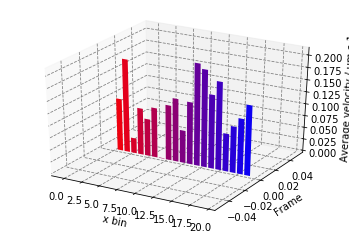

<Figure size 432x288 with 0 Axes>

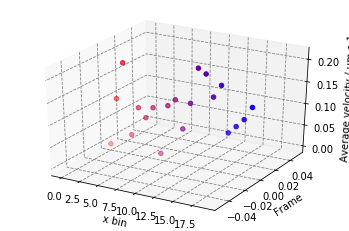

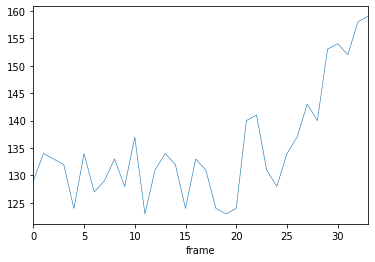

In [18]:
# for each set of calculations requested: run the calculations, then produce the charts based on the results and save them

for c, param in enumerate(pkl_param):
    # the process_pickle function is contained within a separate file - process_pickle.py
    df = process_pickle(pkl_to_process[param[0]], data_dirs[c], param[1], param[2], param[3])
    produce_charts(df, data_dirs[c])
    
    